# Example trials showing acoustic and track data

This notebook will plot 2 example trials:

- 20190704_s1_t10, TC1, trial 223
- 20190703_s2_t4, CT1, trial 196

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.io import wavfile

import pickle

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS, HYDRO_PARAMS
from pp_utils.file_handling import df_main_loader
# from pp_utils.inspection_angle import enso2spheroid_angle

## Set paths and load main info df

In [3]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and figure path

In [4]:
output_path = data_path["main"] / "data_summary"

tp_path = output_path / "trial_processor_object"  # TrialProcessor objects
hydro_wav_path = data_path["main"] / "hydrophone/wav_filtered"  # filtered hydrophone wav files
dtag_filtered_bpf_path = data_path["main"] / "dtag/dtag_split_wav_filtered_bpf"
echogram_path = data_path["main"] / "echogram/batch_gen"
marks_path = data_path["main"] / "echogram/echogram_mark"

In [5]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [6]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

In [7]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

### Load full tracks

In [8]:
# full tracks for usable trials
with open(output_path / "track_all.pickle", "rb") as filein:
    df_track_all = pickle.load(filein)

## Check trial condition

### Used trials

In [9]:
df_main.iloc[223][["TARGET_ANGLE", "SPHEROID", "fname_prefix"]]

TARGET_ANGLE                TC1
SPHEROID                      M
fname_prefix    20190704_s1_t10
Name: 223, dtype: object

In [10]:
df_main.iloc[196][["TARGET_ANGLE", "SPHEROID", "fname_prefix"]]

TARGET_ANGLE               CT1
SPHEROID                     S
fname_prefix    20190703_s2_t4
Name: 196, dtype: object

### Unused but considered trials

In [11]:
df_main.iloc[217][["TARGET_ANGLE", "SPHEROID", "fname_prefix"]]

TARGET_ANGLE               CT2
SPHEROID                     M
fname_prefix    20190704_s1_t4
Name: 217, dtype: object

In [12]:
df_main.iloc[219][["TARGET_ANGLE", "SPHEROID", "fname_prefix"]]

TARGET_ANGLE               CT1
SPHEROID                     M
fname_prefix    20190704_s1_t6
Name: 219, dtype: object

## Plot

In [13]:
MISC_PARAMS

{'th_RL': 140,
 'time_binning_delta': 0.05,
 'buzz_reg_switch': 0.013,
 'num_buzz_for_onset': 30,
 'dist_max': ('DTAG_dist_elliptical', 12),
 'dist_min': ('ROSTRUM_dist_to_target', 0.1),
 'hydro_angle_th_SNR': 25,
 'hydro_angle_th_range': 6,
 'dtag_sens': -179}

In [14]:
HYDRO_PARAMS

{'bkg_len_sec': 3.2e-05,
 'clk_sel_len_sec': 0.000128,
 'perc_before_pk': 30,
 'hydro_sens': -211,
 'recording_gain': 40}

In [15]:
def get_df_before_touch(df):
    return df[df["before_touch"]].copy()

In [16]:
def plot_track(axx):
    V = df_track["ROSTRUM_X"] - df_track["DTAG_X"]
    U = df_track["ROSTRUM_Y"] - df_track["DTAG_Y"]

    axx.plot(
        df_track["DTAG_Y"], df_track["DTAG_X"],
        color="grey", label="Dtag",# marker=".", ls="none"
    )
    axx.plot(
        df_track["ROSTRUM_Y"], df_track["ROSTRUM_X"],
        color="red", alpha=0.5, label="Rostrum",# marker=".", ls="none"
    )
    axx.quiver(
        df_track["DTAG_Y"][::5], df_track["DTAG_X"][::5], 
        U[::5], V[::5], angles='xy', scale_units='xy', scale=1,
        alpha=0.6, color='b', width=0.01
    )
    axx.invert_xaxis()

    axx.plot(
        df_targets["target_cross_pos_y"], df_targets["target_cross_pos_x"],
        "ko", #label="Sphere",
        markersize=7, markerfacecolor="w", markeredgewidth=1.5
    )
    axx.plot(
        df_targets["clutter_cross_pos_y"], df_targets["clutter_cross_pos_x"],
        "kx", #label="Spheroid",
        markersize=7, markerfacecolor="w", markeredgewidth=1.5
    )


In [17]:
# =============
trial_plot = [223, 196]  # 223-M,TC1;  219-M,CT2
waveform_unit_type = "pressure"  # "pressure" or "volt"
# =============

In [18]:
def plot_track_ici(axx):
    im = axx.scatter(
        df_track["ROSTRUM_Y"], df_track["ROSTRUM_X"],
        c=np.log10(df_track["ICI"]*1e3), s=20, cmap="viridis",
        vmax=1.9, vmin=np.log10(2)
    )
    axx.invert_yaxis()
    axx.plot(
        df_targets["target_cross_pos_y"], df_targets["target_cross_pos_x"],
        "ko", label="Sphere (S+)",
        markersize=7, markerfacecolor="w", markeredgewidth=1.5
    )
    axx.plot(
        df_targets["clutter_cross_pos_y"], df_targets["clutter_cross_pos_x"],
        "kx", label="Spheroid (S-)",
        markersize=7, markerfacecolor="w", markeredgewidth=1.5
    )
    
    return im

In [19]:
def plot_angle(axx, color_ch):
    axx.plot(
        df_hydro_ch0["time_corrected"] - touch_time,
        df_hydro_ch0["enso_angle"],  # no flip
        # enso2spheroid_angle(df_hydro_ch0["enso_angle"]),  # flip
        marker="o", markersize=5, ls="none", alpha=1,
        color=color_ch[0], markeredgewidth=0.5, markerfacecolor="none",
    )
    axx.plot(
        df_hydro_ch1["time_corrected"] - touch_time,
        df_hydro_ch1["enso_angle"],  # no flip
        # enso2spheroid_angle(df_hydro_ch1["enso_angle"]),  # flip
        marker="o", markersize=5, ls="none", alpha=1,
        color=color_ch[1], markeredgewidth=0.5, markerfacecolor="none", 
    )
    axx.plot(
        df_angle_far_ch0["time_corrected"] - touch_time,
        df_angle_far_ch0["theta_target"],  # no flip
        # enso2spheroid_angle(df_angle_far_ch0["theta_target"]),  # flip
        marker="^", markersize=5, markerfacecolor="none",
        ls="none", markeredgewidth=0.5, color=color_ch[2]
    )
    axx.plot(
        df_angle_far_ch1["time_corrected"] - touch_time,
        df_angle_far_ch1["theta_target"],  # no flip
        # enso2spheroid_angle(df_angle_far_ch1["theta_target"]),  # flip
        marker="^", markersize=5, markerfacecolor="none",
        ls="none", markeredgewidth=0.5, color=color_ch[3]
    )

In [20]:
def plot_all(col, decision_ha, buzz_ha, color_ch=["C0", "C1", "navy", "darkred"]):
    """
    color_ch[2:3] only used in plot_angle
    """

    # Track
    # ===================================
    ax_track = fig.add_subplot(gs[0, col])
    # ===================================
    plot_track(ax_track)

    
    # Track + ICI
    # ===================================
    ax_track_ICI = fig.add_subplot(gs[1, col])
    # ===================================
    im = plot_track_ici(ax_track_ICI)

    
    # Dtag recording
    # ===================================
    ax_dtag = fig.add_subplot(gs[2, col])
    # ===================================
    ax_dtag.plot(
        dtag_time + dtag_offset_time - touch_time, dtag_sig,
        lw=0.5, color="k", alpha=0.7
    )


    # Hydrophone recording
    # ===================================
    ax_hydro0 = fig.add_subplot(gs[3, col])
    ax_hydro1 = fig.add_subplot(gs[4, col])
    # ===================================
    ax_hydro0.plot(
        hydro_time + hydro_offset_time - touch_time, hydro_sig[:,0],
        lw=0.5, color=color_ch[0], alpha=0.7
    )
    ax_hydro1.plot(
        hydro_time + hydro_offset_time - touch_time, hydro_sig[:,1],
        lw=0.5, color=color_ch[1], alpha=0.7
    )


    # ICI
    # ===================================
    ax_ICI = fig.add_subplot(gs[5, col])
    # ===================================
    ax_ICI.plot(
        df_dtag["time_corrected"] - touch_time, df_dtag["time_corrected"].diff() * 1e3,
        marker=".", markersize=3, ls="none", color="k", alpha=0.7
    )
    ax_ICI.set_yscale("log")


    # Inspection angle
    # ===================================
    ax_angle = fig.add_subplot(gs[6, col])
    # ===================================
    plot_angle(ax_angle, color_ch=color_ch)

    # Echogram
    ax_echogram = fig.add_subplot(gs[7:, col])
    ax_echogram.imshow(
        echogram,
        aspect="auto",
        interpolation="antialiased",
        vmin=-90,
        vmax=-60,
        cmap="magma",
        origin="lower",
        extent=(
            echogram_time_corrected[0] - touch_time,
            echogram_time_corrected[-1] - touch_time,
            echogram_animal_range[0],
            echogram_animal_range[-1],
        ),
    )
#     ax_echogram.plot(df_hydro_ch0["time_corrected"] - touch_time, df_hydro_ch0["dist_to_hydro"])
#     ax_echogram.plot(df_hydro_ch1["time_corrected"] - touch_time, df_hydro_ch1["dist_to_hydro"])


    # Annotate Buzz onset and Decision time
    top_loc = 8 if waveform_unit_type == "pressure" else 0.011
    con1 = ConnectionPatch(
        xyA=(decision_time - touch_time, top_loc),
        xyB=(decision_time - touch_time, 0),
        coordsA="data", coordsB="data",
        axesA=ax_dtag, axesB=ax_echogram, color="darkgrey", ls="--", lw=1.5, capstyle="butt"
    )
    con2 = ConnectionPatch(
        xyA=(buzz_onset_time - touch_time, top_loc),
        xyB=(buzz_onset_time - touch_time, 0),
        coordsA="data", coordsB="data",
        axesA=ax_dtag, axesB=ax_echogram, color="darkgrey", ls="--", lw=1.5, capstyle="butt"
    )
    ax_echogram.add_artist(con1)
    ax_echogram.add_artist(con2)
    
    shift = 0.3
    vert_loc = 8.35 if waveform_unit_type == "pressure" else 0.012
    if decision_ha == "right":
        ax_dtag.text(decision_time-touch_time+shift, vert_loc, "Decision", ha=decision_ha,
                     color="darkgrey", fontsize=14, fontweight="bold")
    else:
        ax_dtag.text(decision_time-touch_time-shift, vert_loc, "Decision", ha=decision_ha,
                     color="darkgrey", fontsize=14, fontweight="bold")
        
    if buzz_ha == "right":
        ax_dtag.text(buzz_onset_time-touch_time+shift, vert_loc, "Buzz", ha=buzz_ha,
                     color="darkgrey", fontsize=14, fontweight="bold")
    else:
        ax_dtag.text(buzz_onset_time-touch_time-shift, vert_loc, "Buzz", ha=buzz_ha,
                     color="darkgrey", fontsize=14, fontweight="bold")
        

    return {
        "track": ax_track,
        "track_ICI": ax_track_ICI,
        "dtag": ax_dtag,
        "hydro0": ax_hydro0,
        "hydro1": ax_hydro1,
        "ICI": ax_ICI,
        "angle": ax_angle,
        "echogram": ax_echogram,
        "im": im
    }


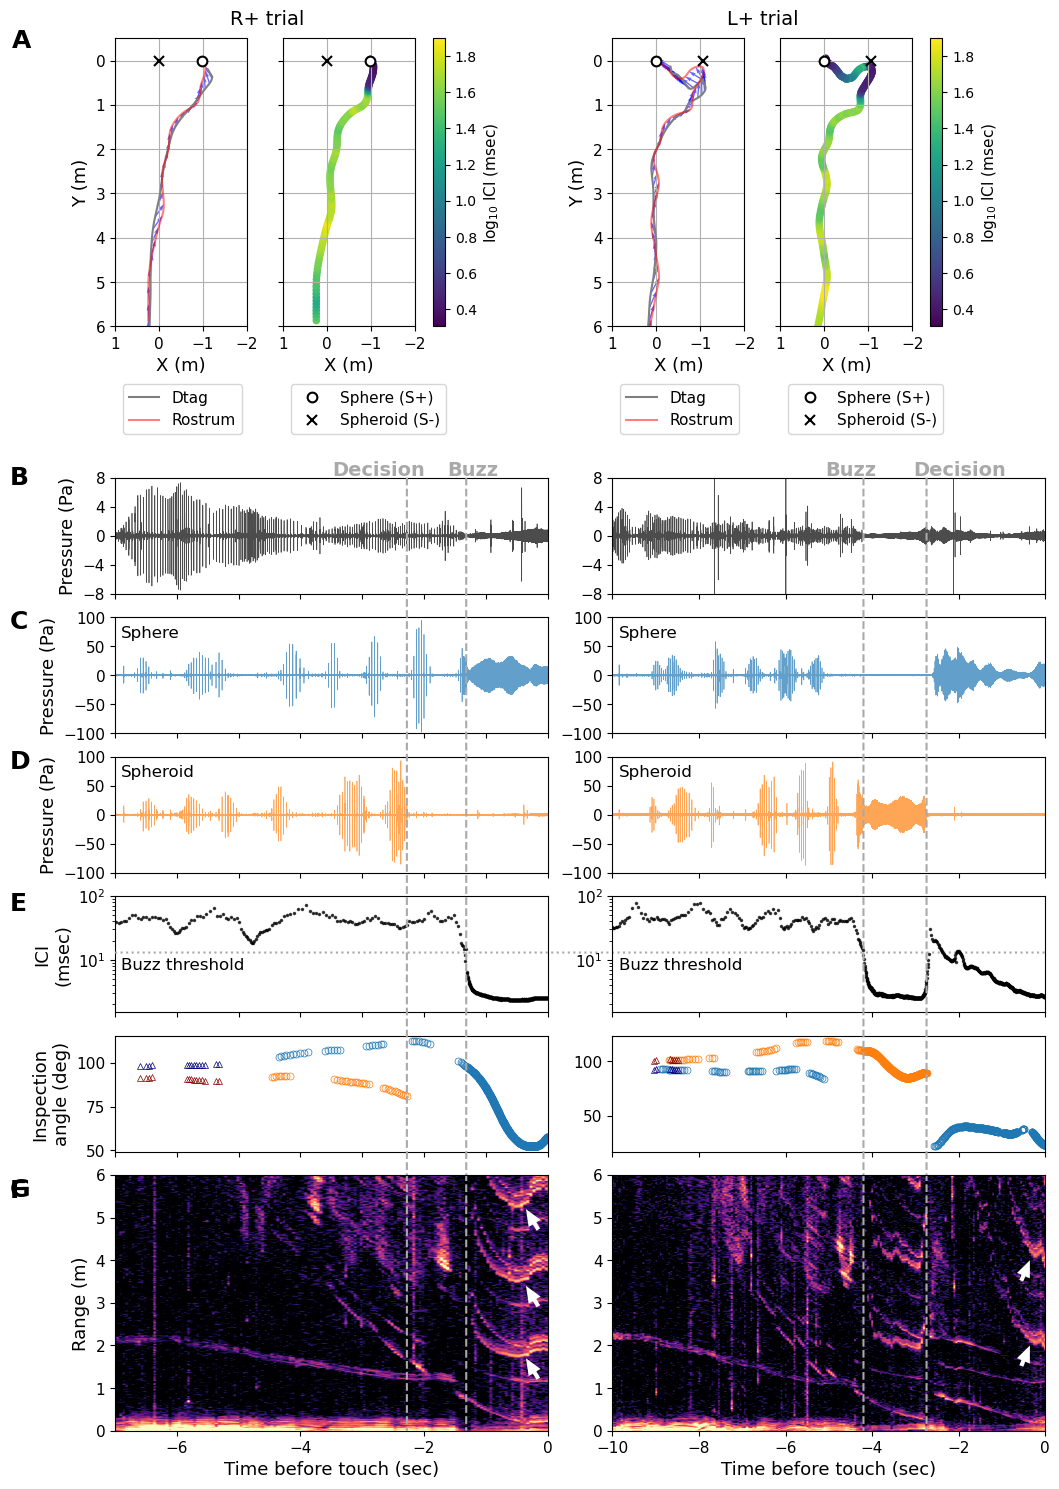

In [21]:
fig = plt.figure(figsize=(12, 16), facecolor="w")

gs = fig.add_gridspec(9, 2)

plt.subplots_adjust(hspace=0.2, wspace=0.15)

ax_all = []
video_first_time = []

for col, trial_idx in enumerate(trial_plot):

    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
        
    # Trial series containing extract summary info
    trial_series = df_summary.iloc[trial_idx]
    
    # Clean up dfs
    df_targets = tp.df_targets
    df_track = get_df_before_touch(tp.df_track.dropna(axis=0))
    df_dtag = get_df_before_touch(tp.df_dtag)
    df_hydro_ch0 = get_df_before_touch(tp.df_hydro_ch0)
    df_hydro_ch1 = get_df_before_touch(tp.df_hydro_ch1)
    decision_time = trial_series["time_decision"]
    buzz_onset_time = trial_series["time_buzz_onset_clean"]
    
    # Compute inspection angles outside of camera view
    df_angle_far_ch0, df_angle_far_ch1 = tp.get_inspection_angle_outside_view(
        hydro_wav_path=hydro_wav_path,
        marks_path=marks_path,
        th_ICI=MISC_PARAMS["buzz_reg_switch"],
        th_SNR=MISC_PARAMS["hydro_angle_th_SNR"],
        th_range=MISC_PARAMS["hydro_angle_th_range"]
    )

    # Get ICI color code for track
    f_ici = interp1d(
        df_dtag.dropna(axis=0)["time_corrected"], df_dtag.dropna(axis=0)["time_corrected"].diff(),
        bounds_error=False, fill_value="extrapolate"
    )
    df_track["ICI"] = f_ici(df_track["time_corrected"])

    # Select clicks to plot
    df_hydro_ch0 = df_hydro_ch0[
        (df_hydro_ch0["RL"] > MISC_PARAMS["th_RL"])
    ].copy()
    df_hydro_ch1 = df_hydro_ch1[
        (df_hydro_ch1["RL"] > MISC_PARAMS["th_RL"])
    ].copy()
    df_hydro_ch0.dropna(subset=["enso_angle"], inplace=True)
    df_hydro_ch1.dropna(subset=["enso_angle"], inplace=True)
    if trial_idx == 223:
        df_hydro_ch1 = df_hydro_ch1[1:]  # remove first stray click


    dtag_offset_time = (tp.df_dtag["time_corrected"] - tp.df_dtag["time"]).mean()
    hydro_offset_time = (tp.df_hydro_ch0["time_corrected"] - tp.df_hydro_ch0["time"]).mean()

    touch_time = df_track.iloc[-1]["time_corrected"]
    
    # First time point with video data
    video_first_time.append(df_track["time_corrected"].values[0] - touch_time)

    # Echogram
    dtag_file = list(dtag_filtered_bpf_path.glob(f"t{trial_idx:03d}_*.wav"))[0]
    dtag_fs, dtag_sig = wavfile.read(dtag_file)
    if waveform_unit_type == "pressure":
        dtag_sig = dtag_sig * 10**(-MISC_PARAMS["dtag_sens"]/20) / 1e6  # sensitivty, uPa to Pa
    dtag_time = np.arange(len(dtag_sig)) / dtag_fs

    hydro_file = list(hydro_wav_path.glob(f"t{trial_idx:03d}_*.wav"))[0]
    hydro_fs, hydro_sig = wavfile.read(hydro_file)
    if waveform_unit_type == "pressure":
        hydro_sig = (
            hydro_sig
            * 10**(-HYDRO_PARAMS["hydro_sens"]/20)  # sensitivity
            * 10**(-HYDRO_PARAMS["recording_gain"]/20)  # gain
            / 1e6  # uPa to Pa
        )
    hydro_time = np.arange(hydro_sig.shape[0]) / hydro_fs

    echogram_file = list(echogram_path.glob(f"t{trial_idx:03d}_*.npz"))[0]
    with np.load(echogram_file) as egram:
        echogram = egram["echogram"]
        echogram_animal_range = egram["animal_range"]
        echogram_time_corrected = egram["time_corrected"]
    
    if col == 0:
        ax_all.append(plot_all(col, decision_ha="right", buzz_ha="left"))
    elif col == 1:
        ax_all.append(plot_all(col, decision_ha="left", buzz_ha="right"))


# Adjust axis for track and ICI track
pos_track_0 = ax_all[0]["track"].get_position()
pos_track_1 = ax_all[1]["track"].get_position()
pos_track_ICI_0 = ax_all[0]["track_ICI"].get_position()
pos_track_ICI_1 = ax_all[1]["track_ICI"].get_position()

track_width = 0.11
track_height = 0.18
ax_all[0]["track"].set_position(
    [pos_track_0.x0, pos_track_ICI_0.y0 + 0.08, track_width, track_height]
)  # left, right, width, height
ax_all[0]["track_ICI"].set_position(
   [ pos_track_0.x0 + 0.14, pos_track_ICI_0.y0 + 0.08, track_width, track_height]
)  # left, right, width, height
ax_all[1]["track"].set_position(
    [pos_track_1.x0, pos_track_ICI_0.y0 + 0.08, track_width, track_height]
)  # left, right, width, height
ax_all[1]["track_ICI"].set_position(
   [ pos_track_1.x0 + 0.14, pos_track_ICI_0.y0 + 0.08, track_width, track_height]
)  # left, right, width, height


# Grid
for seq in range(2):
    ax_all[seq]["track"].grid()
    ax_all[seq]["track_ICI"].grid()


# Colorbar with track ICI
for seq in range(2):
    axx_pos = ax_all[seq]["track_ICI"].get_position()
    cax_track_ICI = fig.add_axes([
        axx_pos.x0+axx_pos.width+0.015, axx_pos.y0, 0.01, axx_pos.height
    ])
    cbar = plt.colorbar(
        ax_all[seq]["im"], cax=cax_track_ICI, orientation="vertical"
    )
    cbar.ax.set_ylabel("log$_{10}$ ICI (msec)", fontsize=11)


# Legends for track and track ICI panels
for seq in range(2):
    for axx in [ax_all[seq]["track"], ax_all[seq]["track_ICI"]]:
        axx.legend(bbox_to_anchor=(1, 8.6), bbox_transform=axx.transData, loc="lower left", fontsize=11)


# Set all tick label font size
for seq in range(2):
    for key, axx in ax_all[seq].items():
        if key != "im":
            axx.tick_params(axis='both', labelsize=11)

# xticks
for axx in [
    ax_all[0]["track"], ax_all[0]["track_ICI"],
    ax_all[1]["track"], ax_all[1]["track_ICI"]
]:
    axx.set_xticks(np.arange(-2, 2, 1))
ax_all[0]["echogram"].set_xticks(np.arange(-20, 1, 2))
ax_all[1]["echogram"].set_xticks(np.arange(-20, 1, 2))


# xlim
# Track and track ICI panels
for seq in range(2):
    for axx in [
        ax_all[seq]["track"], ax_all[seq]["track_ICI"],
    ]:
        axx.set_ylim(6, -0.5)
        axx.set_xlim(1, -2)

# Other panels
for seq in range(2):
    for axx in list(ax_all[seq].values())[2:-1]:  # do not adjust track panels
        if seq == 0:
            axx.set_xlim(-7, 0)   # example 1: left panel
        else:
            axx.set_xlim(-10, 0)  # example 2: right panel

for seq in range(2):
    for axx in list(ax_all[seq].values())[2:-2]:  # do not adjust track panels
        axx.set_xticklabels("")

# yticks
for seq in range(2):
    if waveform_unit_type == "pressure":
        ax_all[seq]["dtag"].set_yticks(np.arange(-8, 8.1, 4))  # Pa
        ax_all[seq]["hydro0"].set_yticks(np.arange(-100, 101, 50))  # Pa
        ax_all[seq]["hydro1"].set_yticks(np.arange(-100, 101, 50))  # Pa
    else:
        ax_all[seq]["dtag"].set_yticks(np.arange(-0.01, 0.015, 0.01))  # Volt
        ax_all[seq]["hydro0"].set_yticks(np.arange(-0.2, 0.3, 0.2))  # Volt
        ax_all[seq]["hydro1"].set_yticks(np.arange(-0.2, 0.3, 0.2))  # Volt
    ax_all[seq]["echogram"].set_yticks(np.arange(0, 20, 1))
    ax_all[seq]["track"].set_yticks(np.arange(0, 7, 1))
    ax_all[seq]["track_ICI"].set_yticks(np.arange(0, 7, 1))
    ax_all[seq]["track_ICI"].set_yticklabels("")

# ylim
for seq in range(2):
    for axx in [ax_all[seq]["hydro0"], ax_all[seq]["hydro1"]]:
        if waveform_unit_type == "pressure":
            axx.set_ylim(-100, 100)  # Pa
        else:
            axx.set_ylim(-0.25, 0.25)  # Volt
    if waveform_unit_type == "pressure":
        ax_all[seq]["dtag"].set_ylim(-8, 8)  # Pa
    else:
        ax_all[seq]["dtag"].set_ylim(-0.011, 0.011)  # Volt
    ax_all[seq]["ICI"].set_ylim(1.5, 100)
    ax_all[seq]["echogram"].set_ylim(0, 6)

# labels
label_size = 13

ax_all[0]["track"].set_xlabel("X (m)", fontsize=label_size)
ax_all[1]["track"].set_xlabel("X (m)", fontsize=label_size)
ax_all[0]["track_ICI"].set_xlabel("X (m)", fontsize=label_size)
ax_all[1]["track_ICI"].set_xlabel("X (m)", fontsize=label_size)
ax_all[0]["echogram"].set_xlabel("Time before touch (sec)", fontsize=label_size)
ax_all[1]["echogram"].set_xlabel("Time before touch (sec)", fontsize=label_size)

ax_all[0]["track"].set_ylabel("Y (m)", fontsize=label_size)
ax_all[1]["track"].set_ylabel("Y (m)", fontsize=label_size)
if waveform_unit_type == "pressure":
    ax_all[0]["dtag"].set_ylabel("Pressure (Pa)", fontsize=label_size)
    ax_all[0]["hydro0"].set_ylabel("Pressure (Pa)", fontsize=label_size)
    ax_all[0]["hydro1"].set_ylabel("Pressure (Pa)", fontsize=label_size)
else:
    ax_all[0]["dtag"].set_ylabel("Volt", fontsize=label_size)
    ax_all[0]["hydro0"].set_ylabel("Volt", fontsize=label_size)
    ax_all[0]["hydro1"].set_ylabel("Volt", fontsize=label_size)
ax_all[0]["ICI"].set_ylabel("ICI\n(msec)", fontsize=label_size)
ax_all[0]["angle"].set_ylabel("Inspection\nangle (deg)", fontsize=label_size)
ax_all[0]["echogram"].set_ylabel("Range (m)", fontsize=label_size)


# Extra annotations
ax_all[0]["track"].set_title("        R+ trial", fontsize=14, ha="left", pad=10)
ax_all[1]["track"].set_title("        L+ trial", fontsize=14, ha="left", pad=10)
ax_all[0]["hydro0"].text(-6.9, 65, "Sphere", fontsize=12)
ax_all[0]["hydro1"].text(-6.9, 65, "Spheroid", fontsize=12)
ax_all[1]["hydro0"].text(-9.85, 65, "Sphere", fontsize=12)
ax_all[1]["hydro1"].text(-9.85, 65, "Spheroid", fontsize=12)
ax_all[0]["ICI"].text(-6.9, 7, "Buzz threshold", fontsize=12)
ax_all[1]["ICI"].text(-9.85, 7, "Buzz threshold", fontsize=12)
con3 = ConnectionPatch(
    xyA=(-7, 13),
    xyB=(-0, 13),
    coordsA="data", coordsB="data",
    axesA=ax_all[0]["ICI"], axesB=ax_all[1]["ICI"], color="darkgrey", ls=":", lw=1.5, capstyle="butt"
)
ax_all[1]["ICI"].add_artist(con3)

ax_all[0]["echogram"].annotate(
    "", xy=(-0.35, 1.7), xytext=(-0.15, 1.22),
    arrowprops=dict(facecolor="w", edgecolor="None", width=3, headwidth=10),
)
ax_all[0]["echogram"].annotate(
    "", xy=(-0.35, 3.4), xytext=(-0.15, 2.92),
    arrowprops=dict(facecolor="w", edgecolor="None", width=3, headwidth=10),
)
ax_all[0]["echogram"].annotate(
    "", xy=(-0.35, 5.2), xytext=(-0.15, 4.72),
    arrowprops=dict(facecolor="w", edgecolor="None", width=3, headwidth=10),
)
ax_all[1]["echogram"].annotate(
    "", xy=(-0.35, 2.0), xytext=(-0.55, 1.52),
    arrowprops=dict(facecolor="w", edgecolor="None", width=3, headwidth=10),
)
ax_all[1]["echogram"].annotate(
    "", xy=(-0.35, 4.0), xytext=(-0.55, 3.52),
    arrowprops=dict(facecolor="w", edgecolor="None", width=3, headwidth=10),
)


# Panel labels
panel_size = 18
ax_all[0]["track"].text(3.35, -0.3, "A", fontsize=panel_size, fontweight="bold")
ax_all[0]["dtag"].text(-8.7, 7, "B", fontsize=panel_size, fontweight="bold")
ax_all[0]["hydro0"].text(-8.7, 80, "C", fontsize=panel_size, fontweight="bold")
ax_all[0]["hydro1"].text(-8.7, 80, "D", fontsize=panel_size, fontweight="bold")
ax_all[0]["ICI"].text(-8.7, 60, "E", fontsize=panel_size, fontweight="bold")
ax_all[0]["angle"].text(-8.7, 23, "F", fontsize=panel_size, fontweight="bold")
ax_all[0]["echogram"].text(-8.7, 5.5, "G", fontsize=panel_size, fontweight="bold")

    
plt.show()

fig.savefig(fig_path / "fig_example_data_noflip.png", dpi=300, bbox_inches="tight")
